# Setup

In [1]:
import csv
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import losses, optimizers, models, layers
import tensorflow as tf

In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_EPOCHS = 30
CLASS_NAMES = ['barcode', 'qr']

MODEL_PATH = 'models/'
MODEL_NAME = 'model'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

# Load the dataset

In [3]:
dataset_path = 'dataset'

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    label_mode='binary',
    shuffle=True
)

Found 992 files belonging to 2 classes.
Using 794 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    label_mode='binary',
    shuffle=False
)

Found 992 files belonging to 2 classes.
Using 198 files for validation.


# Visualize the dataset

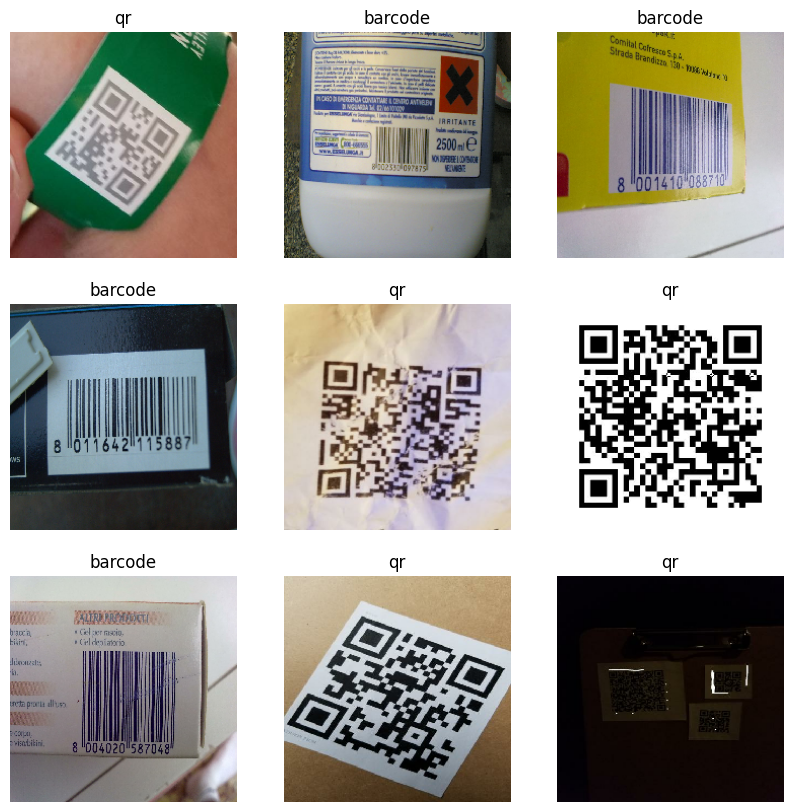

In [83]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[int(labels[i])])
        plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16, 1)


# Configure the dataset

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocess and augment the dataset

In [21]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(1),
    layers.RandomRotation(1)
])

# Create the model

In [51]:
num_classes = len(CLASS_NAMES)

pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model

In [52]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                loss=losses.BinaryCrossentropy(),
                metrics=['binary_accuracy'])

In [53]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

# Train the model

In [54]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3, verbose=1, restore_best_weights=True),
]

In [55]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
50/50 [==============================] - 67s 1s/step - loss: 0.6698 - binary_accuracy: 0.6171 - val_loss: 0.4694 - val_binary_accuracy: 0.8182
Epoch 2/30
50/50 [==============================] - 55s 1s/step - loss: 0.4358 - binary_accuracy: 0.7947 - val_loss: 0.3789 - val_binary_accuracy: 0.8535
Epoch 3/30
50/50 [==============================] - 54s 1s/step - loss: 0.3714 - binary_accuracy: 0.8526 - val_loss: 0.3397 - val_binary_accuracy: 0.8737
Epoch 4/30
50/50 [==============================] - 53s 1s/step - loss: 0.3233 - binary_accuracy: 0.8715 - val_loss: 0.2969 - val_binary_accuracy: 0.8788
Epoch 5/30
50/50 [==============================] - 55s 1s/step - loss: 0.3206 - binary_accuracy: 0.8741 - val_loss: 0.2721 - val_binary_accuracy: 0.8990
Epoch 6/30
50/50 [==============================] - 54s 1s/step - loss: 0.2958 - binary_accuracy: 0.8791 - val_loss: 0.2494 - val_binary_accuracy: 0.9192
Epoch 7/30
50/50 [==============================] - 53s 1s/step - loss: 0.25

# Visualize the training process

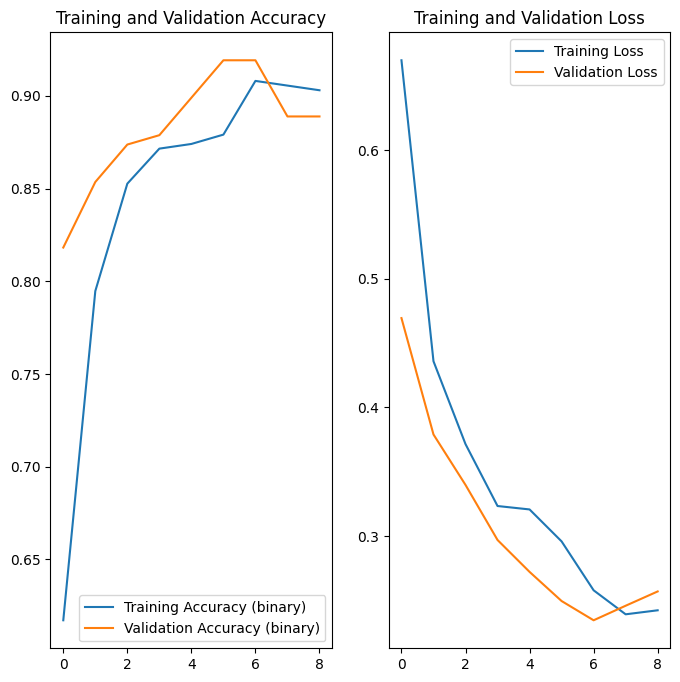

In [56]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy (binary)')
plt.plot(epochs_range, val_acc, label='Validation Accuracy (binary)')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Save the model

In [57]:
model.save(MODEL_PATH + MODEL_NAME)

INFO:tensorflow:Assets written to: models/model\assets


INFO:tensorflow:Assets written to: models/model\assets


In [58]:
reloaded_model = tf.keras.models.load_model(MODEL_PATH + MODEL_NAME)

reloaded_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_12 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 128)              

3/3 [==============================] - 2s 702ms/step
[1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1
 1 1 0 0 1 1 0 1 0 0 1]


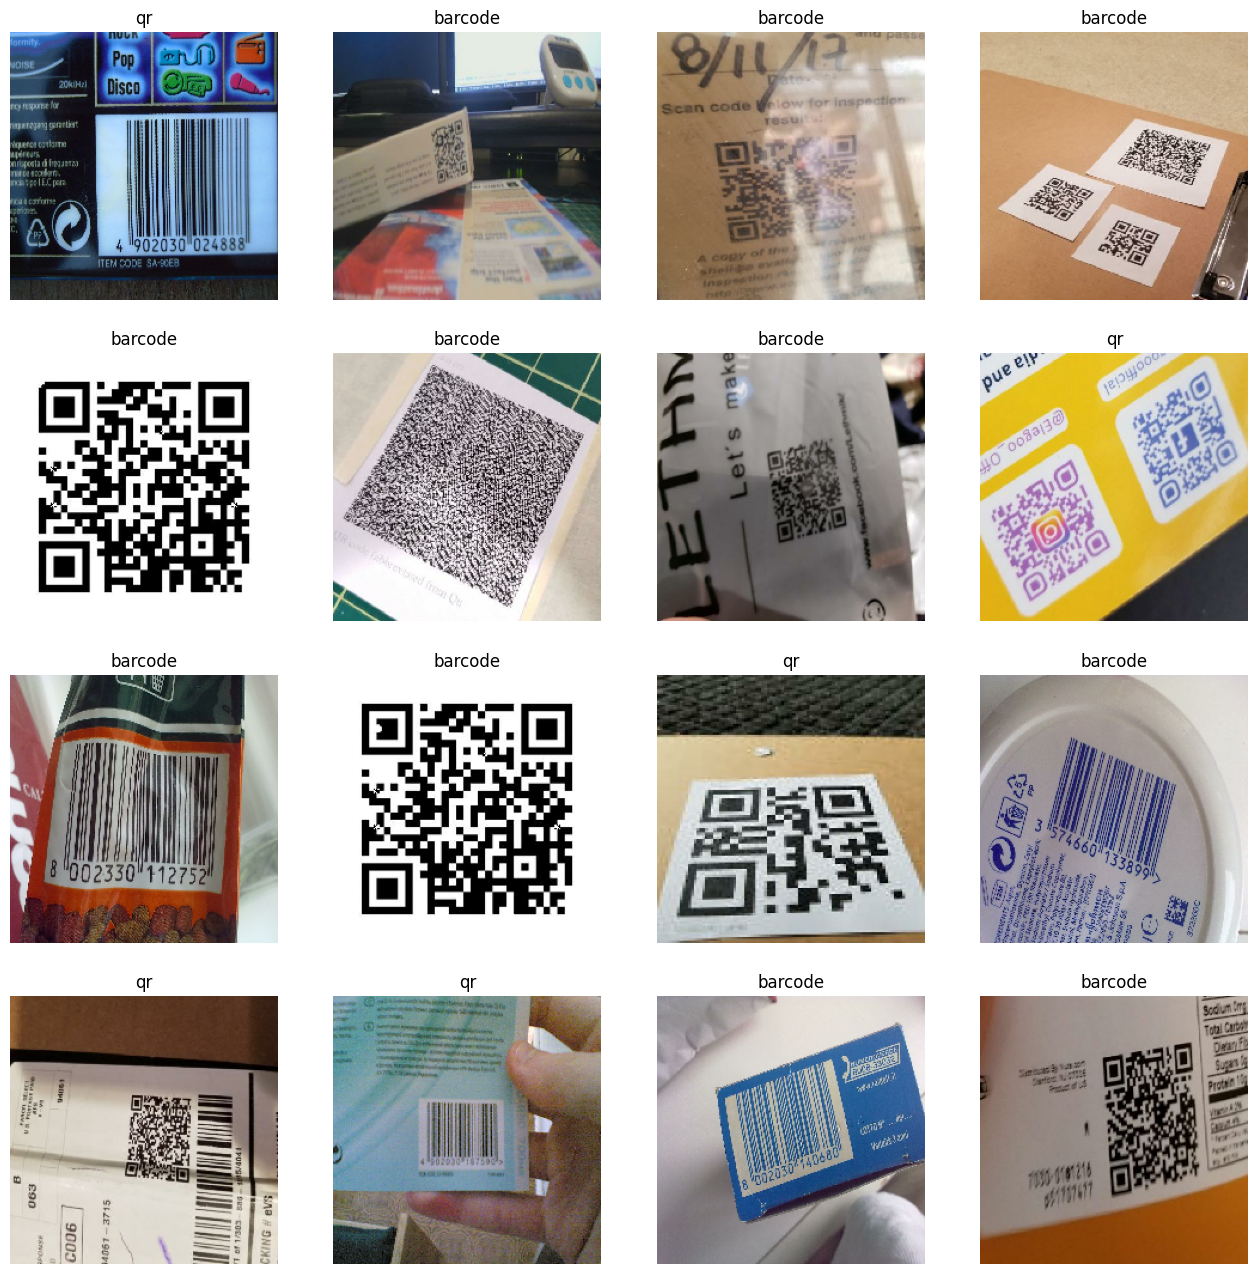

In [93]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5 + 1)

evaluation = reloaded_model.evaluate(test_ds)
predictions = reloaded_model.predict(test_ds)
predictions = np.where(predictions > 0.5, 1, 0)
print(predictions.flatten())

plt.figure(figsize=(16, 16))
for images, labels in test_ds:
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[int(predictions[i])])
        plt.axis("off")